# A Comprehensive Data Analysis on a WhatsApp Group Chat
##### *Author*: [Tushar Nankani](https://www.linkedin.com/in/tusharnankani/)

## *Overview*
- Introduction
- Data Retrieval & Preprocessing
- Exploratory Data Analysis
- Data Visualization
- Data Interpretation
- Summarizing the Inferences
- Conclusion

In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.4 MB/s eta 0:00:00


In [2]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

##### NOTE:
- This special command `%matplotlib inline` to ensure that plots are shown and embedded within the Jupyter notebook itself. Without this command, sometimes plots may show up in pop-up windows.
- `warnings.filterwarnings('ignore')`: The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception). [REFERENCE](https://docs.python.org/3/library/warnings.html)

## *Preparation and reading data*

In [3]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df

    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)

    return df

#### *NOTE*:
- Since WhatsApp texts are *multi-line*, you cannot just read the file line by line and get each message that you want. Instead, you need a way to *identify* if a line is a new message or part of an old message. You could use regular expressions.
- While reading each line, I split it based on a comma and take the first item returned from the `split()` function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.

In [4]:
df = rawToDf('whatsapp-chat-data.txt', '12hr')

## *Prior Information of my Whatsapp Data*
- This is my most active college coding group.
- It has **235+** participants; 237 to be precise.
- This group was made in **January 2020.**

## Pre-Processing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [6]:
df.sample(20)

,date_time,user,message
10966,2020-08-27 22:51:00,+91 98331 51331,She's the best
919,2020-02-17 15:29:00,"Prithvi Rohira (TSEC, CS)",Can someone explain the question first 😅
12527,2020-09-20 14:21:00,"Tanay Kamath (TSEC, CS)",We all want reservation only on basis of wealth
763,2020-02-12 20:41:00,"Dheeraj Lalwani (TSEC, CS)","Also, guys, I'm gonna post a Questionnanre"
4438,2020-04-05 18:33:00,+91 97681 67131,This will work thanks
7975,2020-06-25 13:19:00,"Tanay Kamath (TSEC, CS)",Ha smjha dude😂
10049,2020-08-15 23:15:00,+91 88284 70904,Damn
2629,2020-03-02 22:28:00,"Saurav Upoor (TSEC CS, SE)",<Media omitted>
9626,2020-08-11 21:08:00,"Darshan Rander (TSEC, IT)",Will it be able to take over most popular OS?
5285,2020-04-25 17:12:00,"Pratik K (TSEC CS, SE)",But official rounds are thoda tough 😂


### An important observation
- One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an *empty string.*
- This can be because, the message might just contain **emojis.**
#### To see, how many such rows are there, we can use `df[df['message'] == ""].shape[0]`

In [7]:
df[df['message'] == ""].shape[0]

538

## Adding extra *helper columns for analysis and visualization*

In [8]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

# Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.
### Final Data Frame

In [9]:
df

,date_time,user,message,day,month,year,date
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sun,Jan,2020,2020-01-26
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Fri,Jan,2020,2020-01-24
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sun,Jan,2020,2020-01-26
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sun,Jan,2020,2020-01-26
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sun,Jan,2020,2020-01-26
...,...,...,...,...,...,...,...
13650,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,Fri,Oct,2020,2020-10-02
13651,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,Fri,Oct,2020,2020-10-02
13652,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,Fri,Oct,2020,2020-10-02
13653,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,Fri,Oct,2020,2020-10-02


# *Data Analysis*

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist).**
- Ghosts present in the group. (shocking results.)

**4. Top 10 users most sent media.**

**5. Top 10 most used emojis.**

**6. Most active hours and days.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

# 1. Overall frequency of total messages on the group.
- I will first do this to get a look at overall data.

I will plot a simple line graph to see the frequency of messages over the months.
##### I expect to see a nice line graph with crests and troughs in odd places.

In [10]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2020-01-24,1
1,2020-01-26,105
2,2020-01-27,90
3,2020-01-28,126
4,2020-01-29,118
...,...,...
237,2020-09-28,144
238,2020-09-29,49
239,2020-09-30,167
240,2020-10-01,91


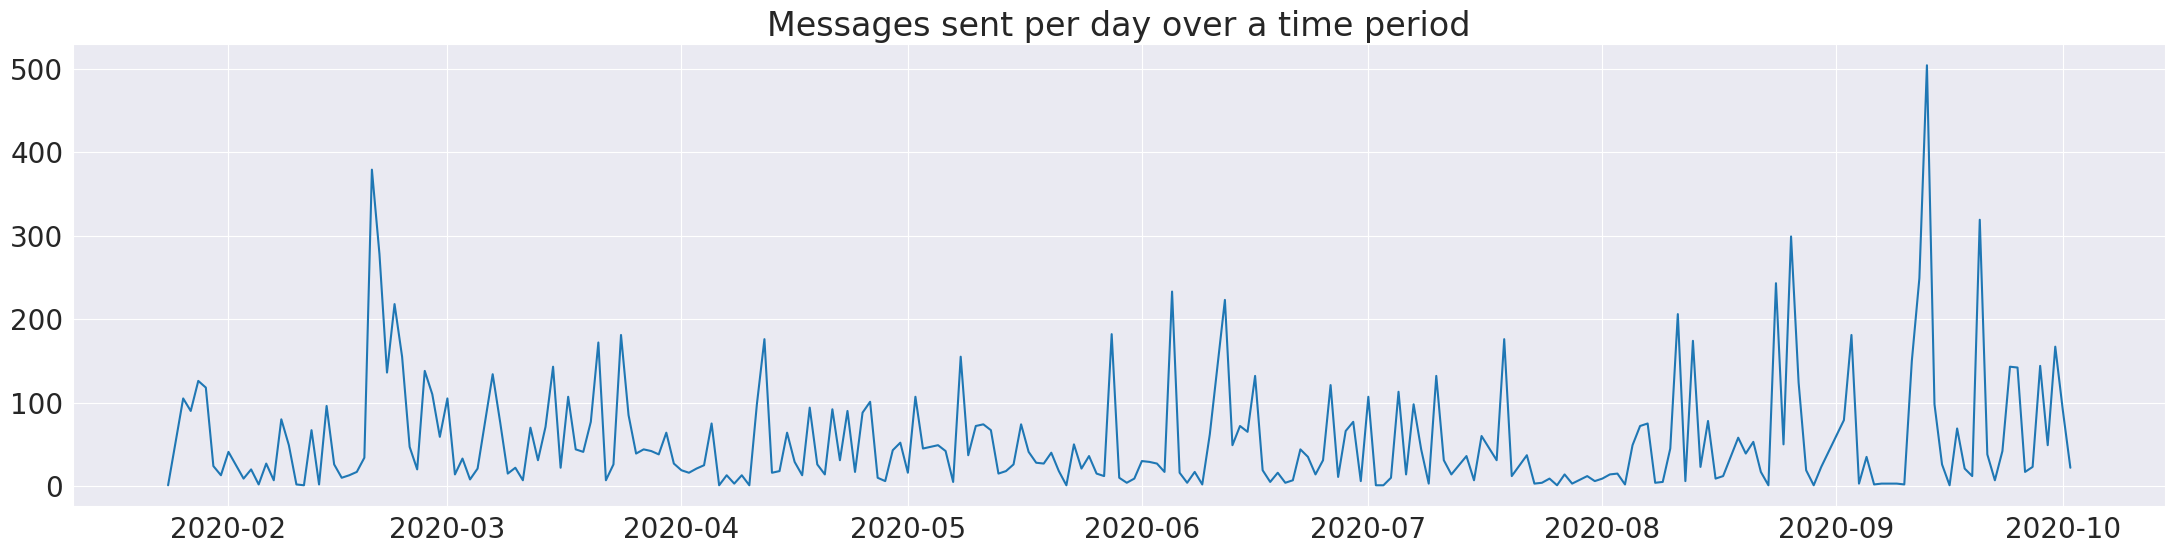

In [11]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


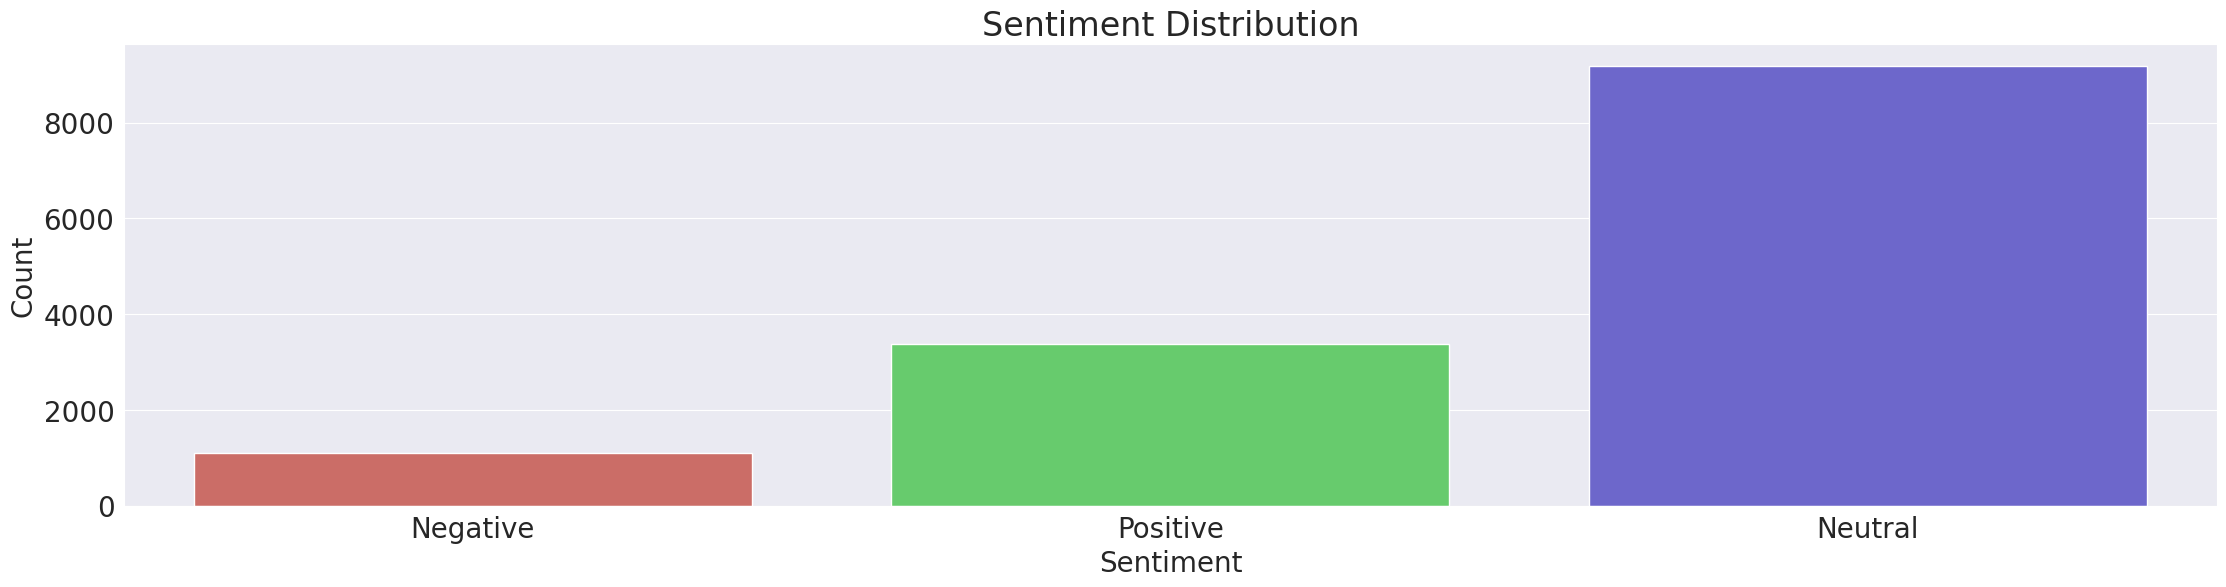

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

nltk.download('vader_lexicon')

def analyze_sentiment(message):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(message)

    if sentiment_scores['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Assuming you have a DataFrame 'df' with columns 'date_time' and 'message'
df['sentiment'] = df['message'].apply(analyze_sentiment)

# Creating a countplot to visualize sentiment distribution
sns.countplot(data=df, x='sentiment', palette="hls")
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Saving the plot
plt.savefig('sentiment_distribution.png', format='png')

# Show the plot
plt.show()


# 2 *Top 10 most active days.*

In [13]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2020-09-13,504
1,2020-02-20,379
2,2020-09-20,319
3,2020-08-26,299
4,2020-02-21,278
5,2020-09-12,249
6,2020-08-24,243
7,2020-06-05,233
8,2020-06-12,223
9,2020-02-23,218


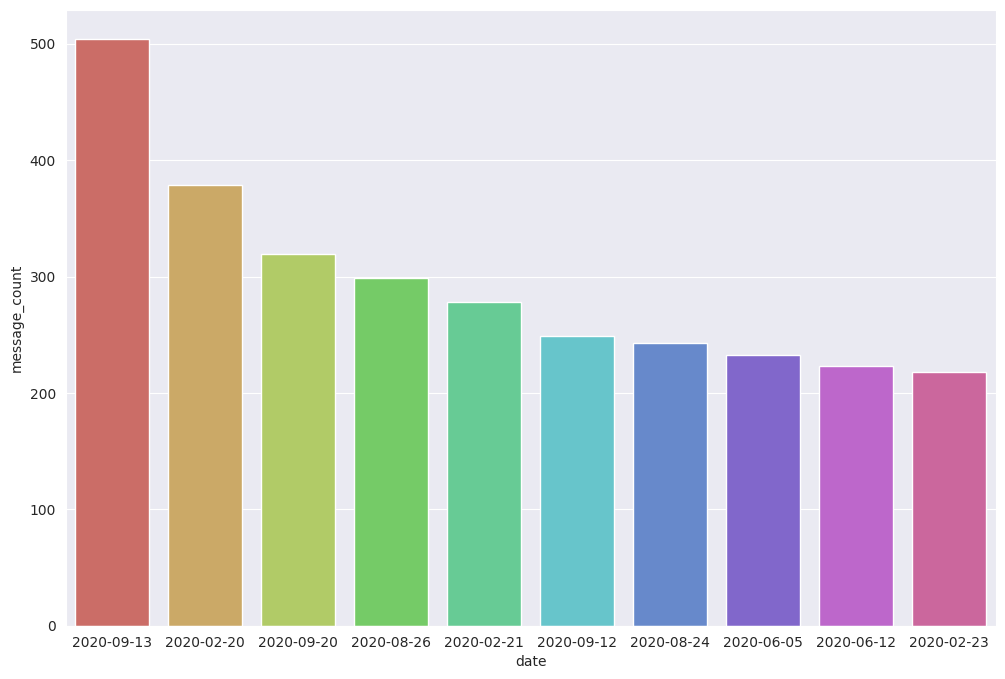

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readability
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Assuming 'top10days' is defined with 'date' and 'message_count' columns
# A bar plot for top 10 days
sns.barplot(data=top10days, x='date', y='message_count', palette="hls")

# Saving the plots
plt.savefig('top10_days.svg', format='svg')


#### Apparently, the group was very active on 13th Spetember'20
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [15]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

## Now, pre-processing top 10 active users.

In [16]:
df2 = df.copy()
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [17]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]

top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

### Starting with a basic plot.
- [Color References for Matplotlib](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

- **Improving Default Styles using Seaborn**

    - [References](https://seaborn.pydata.org/generated/seaborn.set_style.html)

In [18]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

##### Plotting a simple line graph.

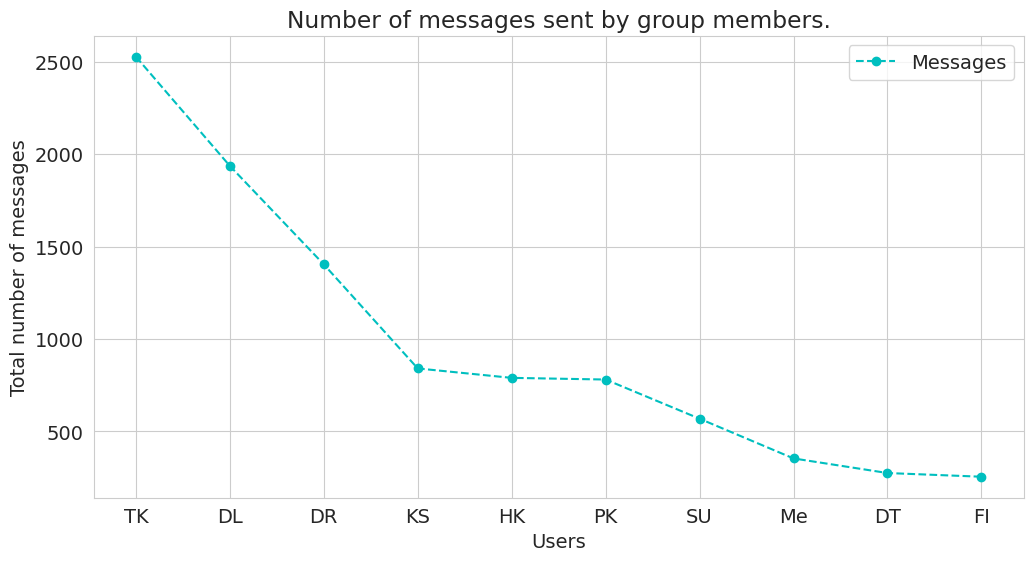

In [19]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')


# Labels and Title
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

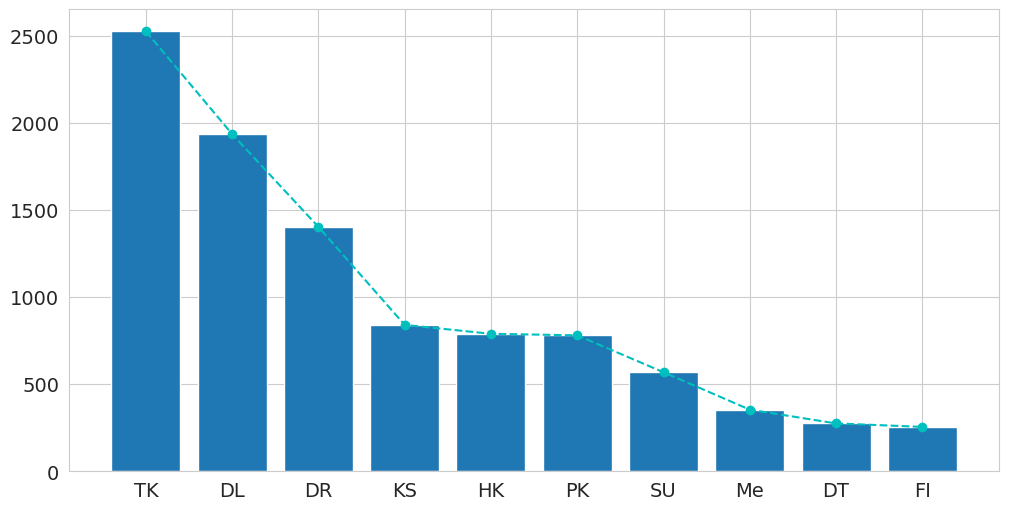

In [20]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

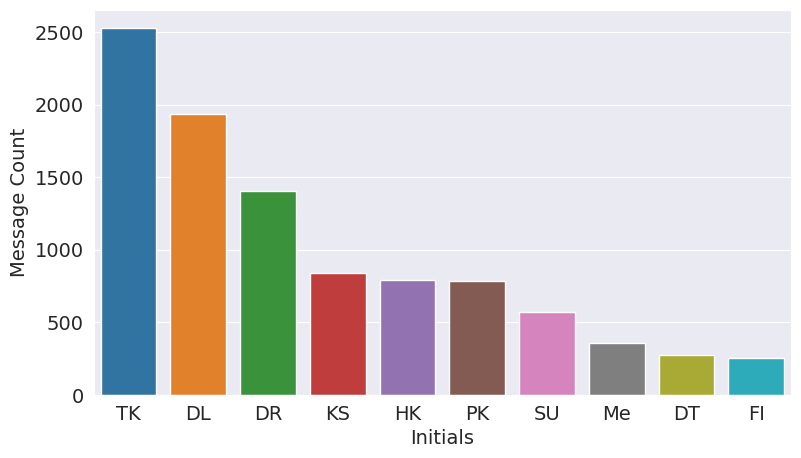

In [21]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Assuming 'top10df' is a DataFrame with 'initials' and 'message' columns
sns.barplot(x='initials', y='message', data=top10df)

# Adding labels to the axes (optional)
plt.xlabel('Initials')
plt.ylabel('Message Count')

# Display the plot (if using Jupyter Notebook or interactive environment)
plt.show()


# *Important Note*

- Since almost all the plots will be ***comparing* one person with another**, I’ll assign a **specific colour to each person** so that it becomes **easy to identify** each person among *multiple plots*.

- I could've used *seaborn's color palette* but:
    - Seaborn assigns default colors itself, but i wanted the color of a **certain person remains the same, no matter the plot**;
    - Also, I wanted to try some different colors so I grabbed my **colour palette** from https://coolors.co/

- Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the `pallete` argument in a seaborn plotting function.

## Defining a function to tackle the problem.

I'm defining the following function to ***maintain consistent colors for each person across all plots***. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that **the color of a certain person remains the same no matter the plot**. This will help maintain **consistency and readability** amongst the many graphs I will be plotting.


In [22]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''

    order = list(names_in_certain_order)
    return_list = []

    for name in order:
        return_list.append(color_dict[name])

    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

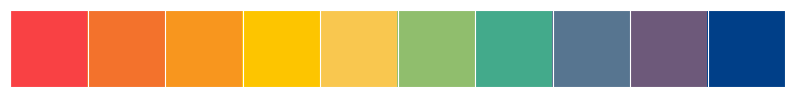

In [23]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [24]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

## Now, we will be plotting *most sent messages* and respective *average message lengths* simultaneously, to see some interesting results.
- Plotting multiple charts in a grid
    - Matplotlib and Seaborn also support plotting multiple charts in a grid, using `plt.subplots`, which returns a set of axes that can be used for plotting.

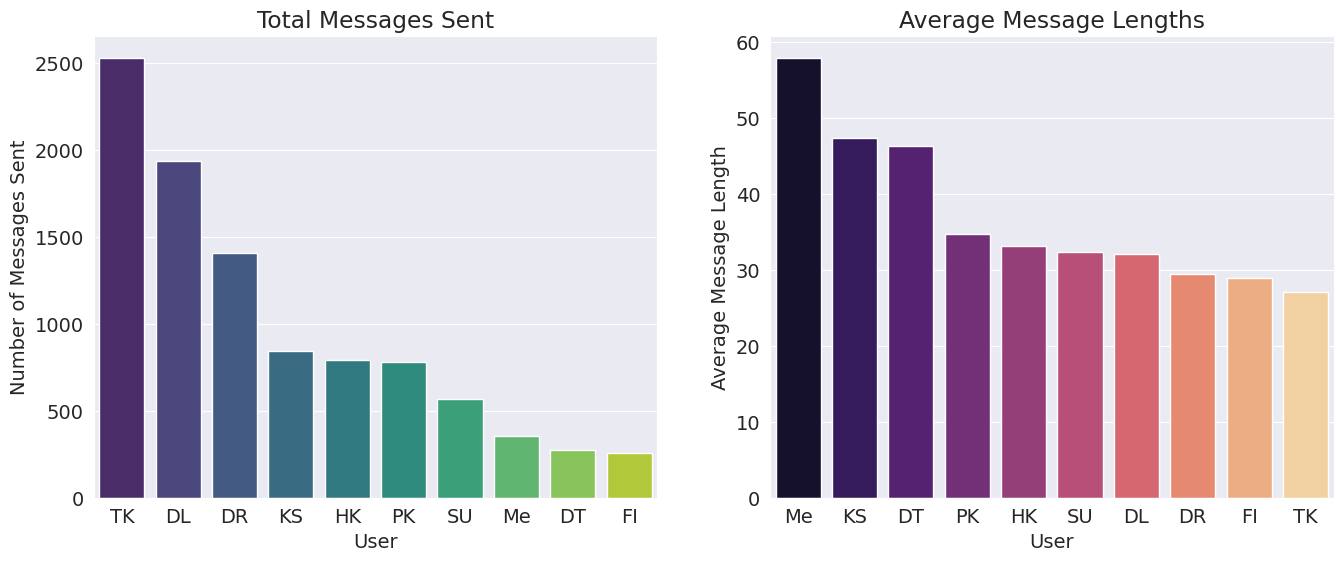

In [25]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Beautify default styles using Seaborn
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(x='initials', y='message', data=top10df, ax=axes[0], palette='viridis')  # Use a suitable palette
axes[0].set_title('Total Messages Sent')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Plot 2 - Barplot of top 10 users' average message lengths
sns.barplot(x='initials', y='avg_message_length', data=top10df_msg, ax=axes[1], palette='magma')  # Use a suitable palette
axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Message Length')

# Saving the plots to an SVG file
plt.savefig('top10_msg_plots_diff.svg', format='svg')

# Display the plots
plt.show()


### It’s really interesting to see plots like this *side by side*, because here comes the twist:

- Ironically, **TK**, the person who sent the **most amount of texts** (2000+), has ***least*** messages' length on *average*. This means this person sends broken and many WhatsApp messages in one go.

- We can see that, **I** send less number of messages while having a **relatively longer message length**, followed by **KS**.

- Here's a **snippet** of how TK sends messages:

<img src="https://imgur.com/xznZczG.png">

#### "*Things aren't always the way they seem like.*"

# 4. Top 10 users most sent media

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`.

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [26]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

### *Visualization using different Seaborn's Color Palettes*
- [Seaborn References](http://seaborn.pydata.org/tutorial/color_palettes.html#using-circular-color-systems)
- [Seaborn's Different Colors](https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08)
- [Seaborn's Color Visualization](https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/)

###### QUICK HACK
- to get **all possible Seaborn's color palettes**:
    - Just put a random input `palette="xyz"`
    - It will then show an error, showing all possible palettes you can try out from!

### Which user sends the most media?

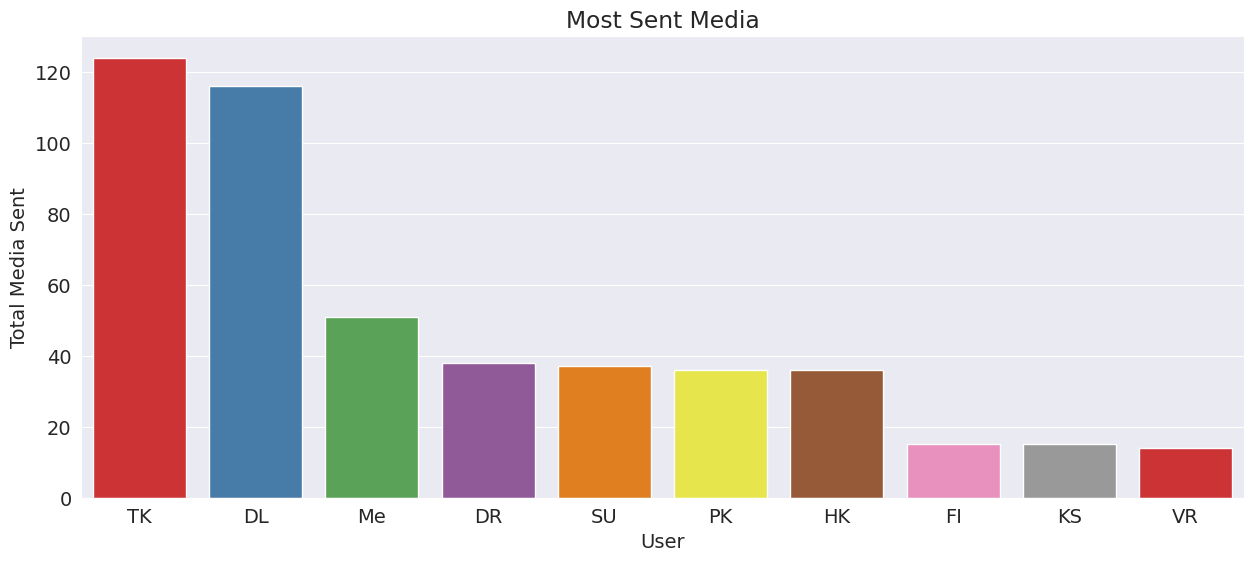

In [27]:
# Increase the figure size
plt.figure(figsize=(15, 6))

# Beautify default styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph
sns.barplot(x='initials', y='media_sent', data=top10media, palette='Set1')  # Use a suitable palette

# Labels and title
plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent')

# Saving the plot to an SVG file
plt.savefig('top10media.svg', format='svg')

# Display the plot (optional)
plt.show()


### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [28]:
import re
from collections import Counter

# Initialize the Counter for emojis
emoji_ctr = Counter()

# Define a list of emojis you want to count
emojis_list = ['😀', '😃', '😄', '😁', '😆', '😅', '😂', '🤣', '😊', '😇']  # Add more emojis as needed

# Create a pattern to match emojis
emoji_pattern = re.compile('|'.join(re.escape(p) for p in emojis_list))

# Iterate through DataFrame rows
for idx, row in df.iterrows():
    # Find emojis in the "message" column
    emojis_found = emoji_pattern.findall(row["message"])
    # Update the counter with the count of each emoji found
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

# Now, emoji_ctr contains the count of each emoji in the DataFrame


#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [29]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"})
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin

    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,1886,face_with_tears_of_joy
1,😅,220,grinning_face_with_sweat
2,🤣,128,rolling_on_the_floor_laughing
3,😁,14,beaming_face_with_smiling_eyes
4,😊,7,smiling_face_with_smiling_eyes
5,😄,4,grinning_face_with_smiling_eyes
6,😃,4,grinning_face_with_big_eyes
7,😇,3,smiling_face_with_halo
8,,0,
9,,0,


### Which Emoji is the most used in the chat?

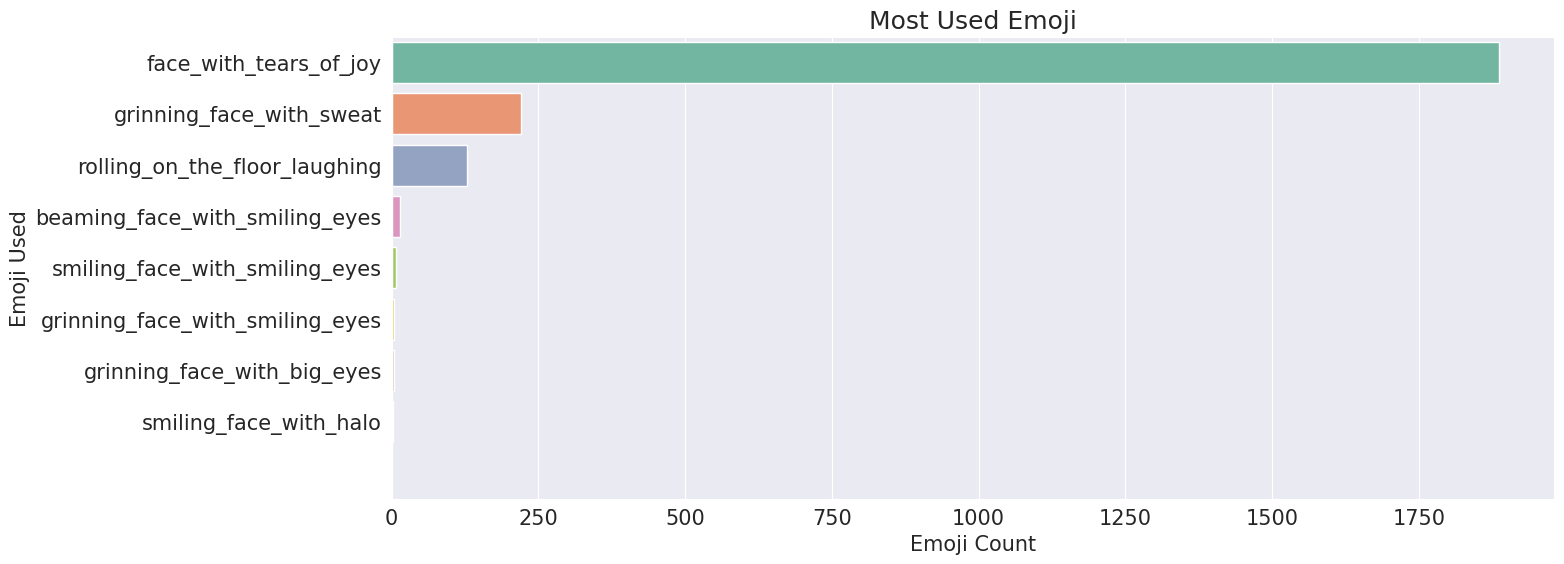

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(15, 6))

# Set font size for better readability
matplotlib.rcParams['font.size'] = 15

# Beautify default styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph
sns.barplot(x='emoji_count', y='emoji_description', data=top10emojis, palette='Set2')  # Use a suitable palette

# Labels and title
plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used')

# Saving the plot to an SVG file
plt.savefig('top10emoji.svg', format='svg')

# Display the plot (optional)
plt.show()


#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [31]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

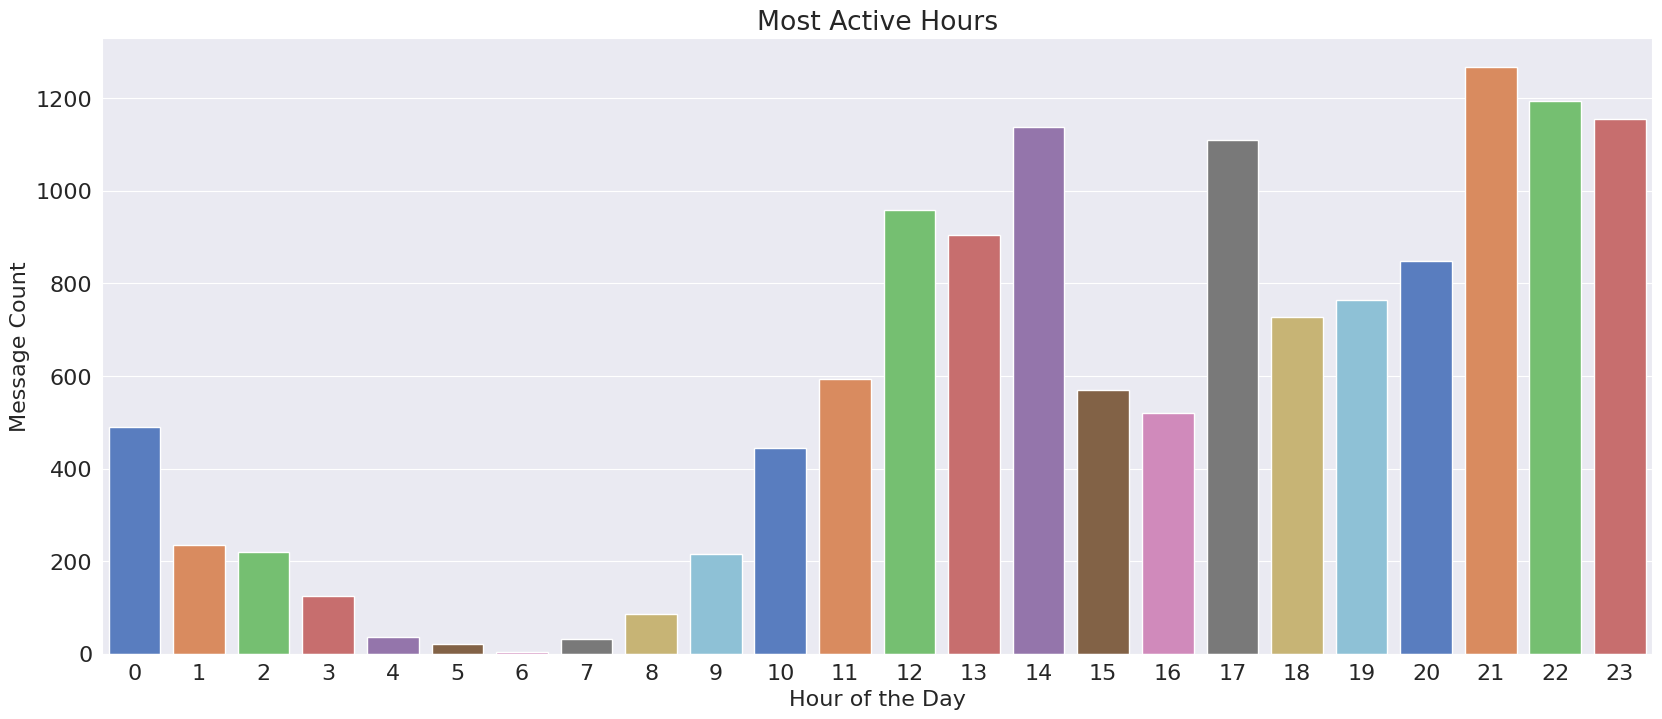

In [32]:
# Increase the figure size and set font size for better readability
matplotlib.rcParams['figure.figsize'] = (20, 8)
matplotlib.rcParams['font.size'] = 16

# Beautify default styles using Seaborn
sns.set_style("darkgrid")

# Create the bar plot (assuming 'grouped_by_time' is defined)
sns.barplot(x='hour', y='message_count', data=grouped_by_time, palette='muted')  # Use a suitable palette

# Labels and title
plt.title('Most Active Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Message Count')

# Saving the plot to an SVG file
plt.savefig('most_active_hours.svg', format='svg')

# Display the plot (optional)
plt.show()


#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

In [33]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]


## *Visualization*
### Now, we will be plotting *grouped by day* and respective *group by month* simultaneously, to see some interesting results.
- Using `plt.subplots` to plot multiple charts in a grid.

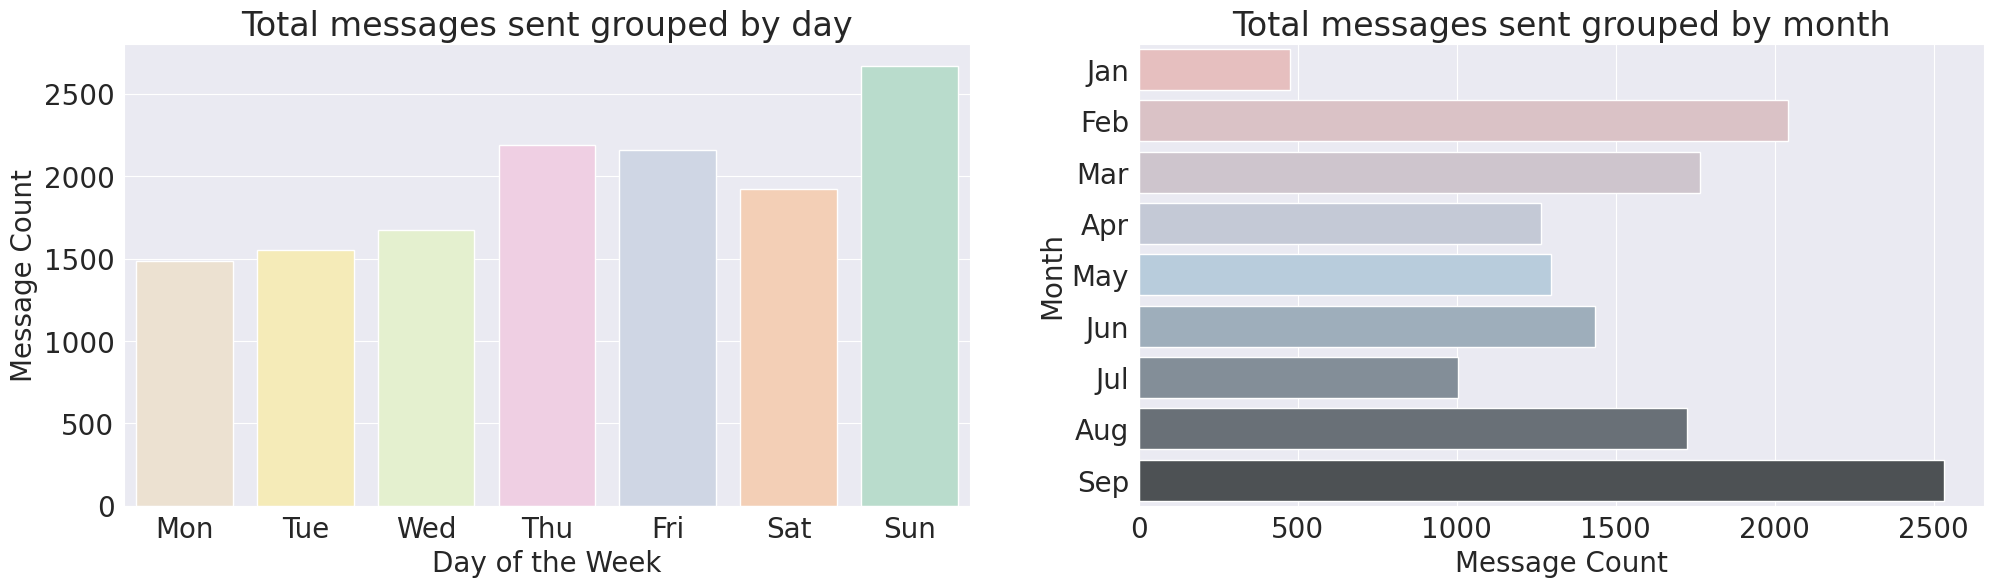

In [34]:
# Increase the figure size and set font size for better readability
matplotlib.rcParams['figure.figsize'] = (24, 6)
matplotlib.rcParams['font.size'] = 20

# Beautify default styles using Seaborn
sns.set_style("darkgrid")

# Create subplots
fig, axs = plt.subplots(1, 2)

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, order=days, ax=axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')
axs[0].set_xlabel('Day of the Week')
axs[0].set_ylabel('Message Count')

# PLOT 2: Messages grouped by months
sns.barplot(y=grouped_by_month.month, x=grouped_by_month.message_count, order=months, ax=axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month')
axs[1].set_xlabel('Message Count')
axs[1].set_ylabel('Month')

# Saving the plots to an SVG file
plt.savefig('days_and_month.svg', format='svg')

# Display the plots (optional)
plt.show()


##### The group is most active on Sundays, and least active on Mondays (probably *Monday Blues*)
##### It has been recently very active, in September.

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding!

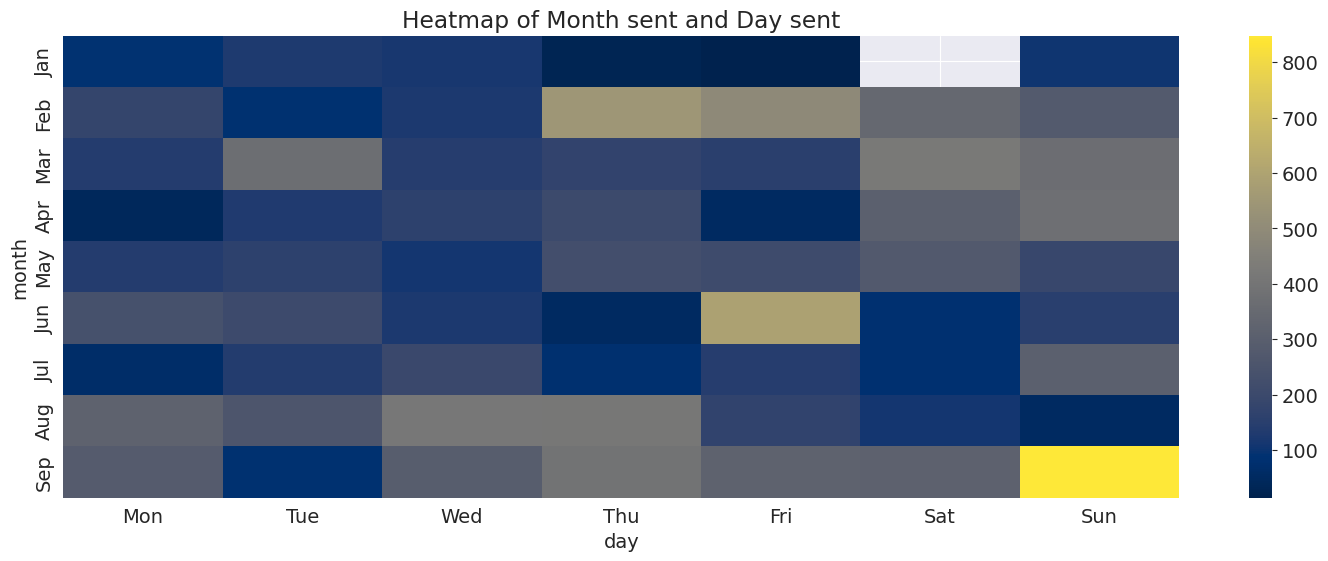

In [35]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

# *Inferences*
- The group is more active on weekends, throughout the months.
- September has the most lighter blue shades and more yellow gradients.
- This gives a combined analysis, which is really helpful in real-time projects.

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [36]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:

    # typecaste each val to string.
    val = str(val)

    # split the value.
    tokens = val.split()

    # Converts each token into lowercase.
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for words in tokens:
        comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 8).generate(comment_words)

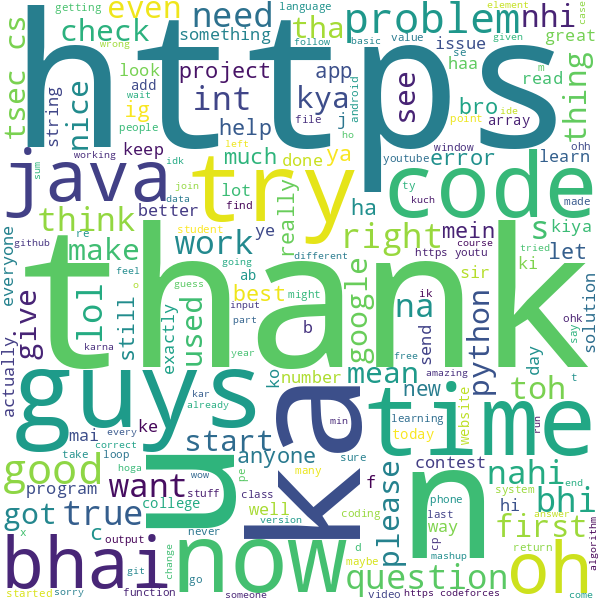

In [37]:
wordcloud.to_image()

# *Conclusion*

- The insights were really interesting to look at!

- We first loaded the data as a .txt file coverted it using `RawtoDF` function.
- Then  we added helper columns, manipulated datetime entries.
- Then, we started analysing our whatsapp data!

Here is what we looked at!

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist - Most active user had the least average message length ).**
- Ghosts present in the group. (shocking results - 80+ participants who haven't even sent a single message!)

**4. Top 10 users most sent media.**
- *TK* beats everyone by a mile!

**5. Top 10 most used emojis.**
- using the `emoji` module!

**6. Most active hours and weekdays.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

### That's it from my end! I hope you *learnt and enjoyed* a lot!

# *Where to go from here?*

- Extending this **Whatsapp Ananlysis Project**!
  - Adding a **Sentiment Analyser to the texts** - Swear Words & Sentiments!
  - Libraries called `profanity_check`, `TextBlob`
  - VADER (Valence Aware Dictionary and Sentiment Reasoner) from NTLK and TextBlob.
- Instagram Data Analysis
- Play Store Data Analysis
- Exploring more datasets! It is *never-ending*, as there can be ***Infinite Stories with Data***!
- Once, done with enough Data Analysis, try making Datasets, scraping Data from websites and creating Interesting Datasets!

# *Thank You*
- [Tushar Nankani](https://www.linkedin.com/in/tusharnankani/)